In [3]:
#Load data and plot
DATASET_DIR = "/home/erdem/dataset/patches_urine_32_scaled"
CATEGORIES_ALL = ["Artifact", "BC", "cCry", "Dirt", "hCast", "LD", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "Unclassified", "WBC"]
CATEGORIES_INLIER = ["BC", "cCry", "hCast", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "WBC"]
CATEGORIES_OUTLIER = ["Artifact", "Dirt", "LD"]

In [4]:
import os
import cv2
import logging
import numpy as np
import methods
import torch as th
from skimage.util import random_noise
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm
import albumentations as A

from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.2)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [5]:
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, rotate_limit=90, scale_limit=[0,0.3], always_apply=True, p=1)
])

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
dim = (32, 32)
height, width = dim
transformed_cCry = methods.getTransformedImages("cCry", dim, transform, 200)
transformed_sCry = methods.getTransformedImages("sCry", dim, transform, 40)
transformed_uCry = methods.getTransformedImages("uCry", dim, transform, 40)
transformed_hCast = methods.getTransformedImages("hCast", dim, transform, 200)
transformed_nhCast = methods.getTransformedImages("nhCast", dim, transform, 200)
transformed_nsEC = methods.getTransformedImages("nsEC", dim, transform, 20)
transformed_sEC = methods.getTransformedImages("sEC", dim, transform, 20)
transformed_WBC = methods.getTransformedImages("WBC", dim, transform, 10)
transformed_RBC = methods.getTransformedImages("RBC", dim, transform, 10)
transformed_BC = methods.getTransformedImages("BC", dim, transform, 4)

transformed_all = np.concatenate((transformed_cCry, transformed_sCry, transformed_uCry, transformed_hCast, 
                                 transformed_nhCast, transformed_nsEC, transformed_sEC, transformed_WBC,
                                 transformed_RBC, transformed_BC))

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers_loop = [testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC]
X_outliers_loop = [testImages_Artifact, testImages_Dirt, testImages_LD]

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [6]:
inlier_dataset = []
outlier_dataset = []

def createInlierData():
    for category in CATEGORIES_INLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                inlier_dataset.append(img_array)
            except Exception as e:
                pass

def createOutlierData():
    for category in CATEGORIES_OUTLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                outlier_dataset.append(img_array)
            except Exception as e:
                pass

In [7]:
createInlierData()
createOutlierData()

X_inlier = np.array(inlier_dataset).reshape(-1, 32, 32, 1)
X_inlier = X_inlier.astype('float32') / 255
np.random.shuffle(X_inlier)

X_outlier = np.array(outlier_dataset).reshape(-1, 32, 32, 1)
X_outlier = X_outlier.astype('float32') / 255
# np.random.shuffle(X_outlier)

X_large_inlier = transformed_all.reshape(-1, 32, 32, 1)
X_large_inlier = X_large_inlier.astype('float32')/255

print(X_inlier.shape)
print(X_outlier.shape)
print(X_large_inlier.shape)

(21416, 32, 32, 1)
(113, 32, 32, 1)
(229732, 32, 32, 1)


In [22]:
latent_dim = 256

encoder_net = tf.keras.Sequential(
[
    layers.InputLayer(input_shape=(32,32, 1)),
    layers.Conv2D(64, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(128, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(512, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Flatten(),
    layers.Dense(latent_dim,)
])
encoder_net.summary()

decoder_net = tf.keras.Sequential(
[
    layers.InputLayer(input_shape=(latent_dim,)),
    layers.Dense(4*4*512),
    layers.Reshape(target_shape=(4, 4, 512)),
    layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')
])
decoder_net.summary()

# initialize outlier detector
od = OutlierVAE(threshold=0.01,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=2,
                beta = 1)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 512)         590336    
_________________________________________________________________
flatten_62613 (Flatten)      (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
Total params: 2,762,240
Trainable params: 2,762,240
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)          

In [23]:
# train
od.fit(X_inlier,
        loss_fn=elbo,
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
        cov_elbo=dict(cov_diag=None),
        epochs=100,
        batch_size=144,
        verbose=True)

149/149 [=] - 6s 42ms/step - loss: -1466.5251


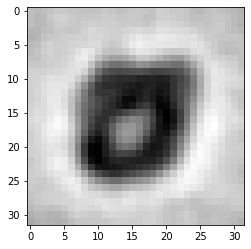

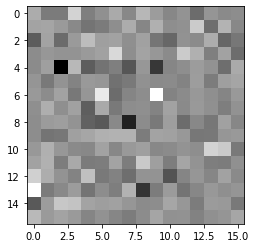

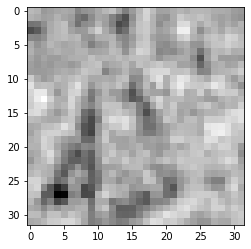

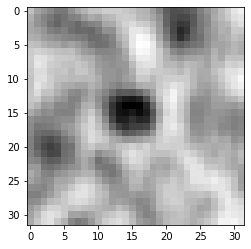

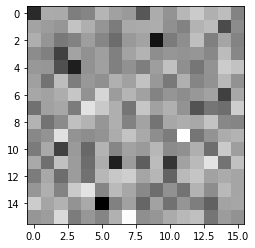

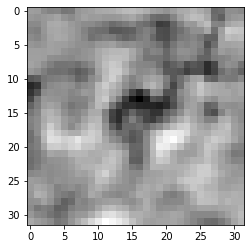

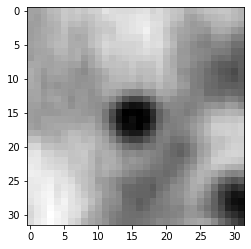

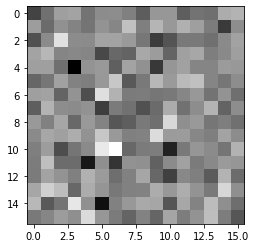

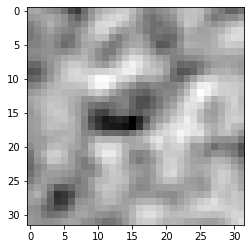

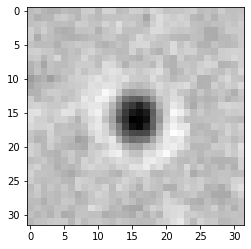

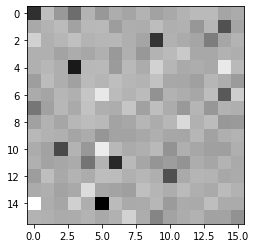

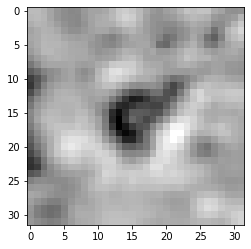

In [24]:
idx = 2094
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net.predict(X)
X_recon = decoder_net.predict(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1004
X = X_inlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1002
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1000
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()

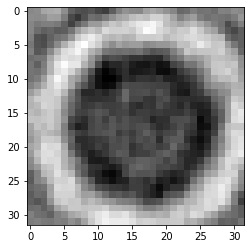

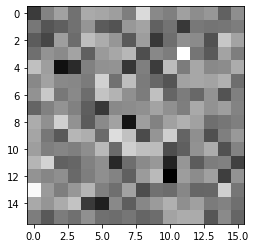

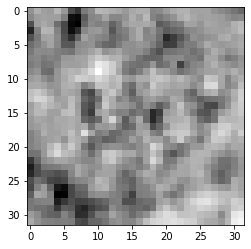

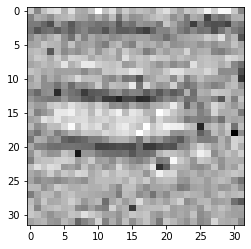

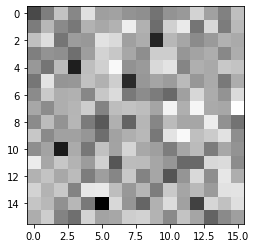

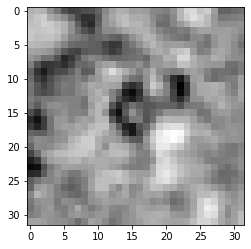

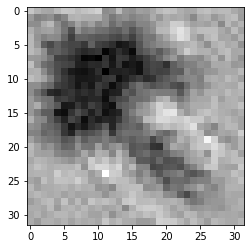

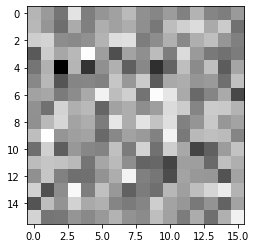

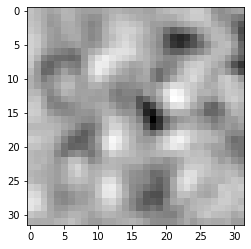

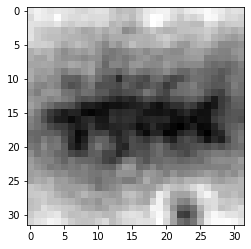

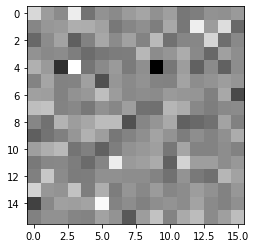

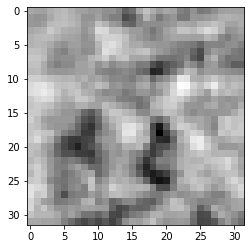

In [25]:
idx = 10
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net.predict(X)
X_recon = decoder_net.predict(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 2
X = X_outlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 54
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 78
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()

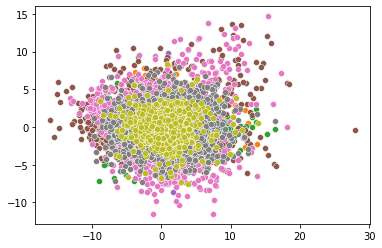

In [26]:
pca = PCA(n_components = 2)

for inlier in X_inliers_loop:
    X_encoded = encoder_net.predict(inlier)
    X_transform = pca.fit_transform(X_encoded)
    a = sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1])

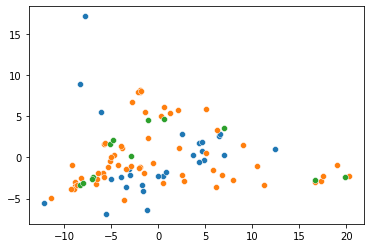

In [27]:
for inlier in X_outliers_loop:
    X_encoded = encoder_net.predict(inlier)
    X_transform = pca.fit_transform(X_encoded)
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1])

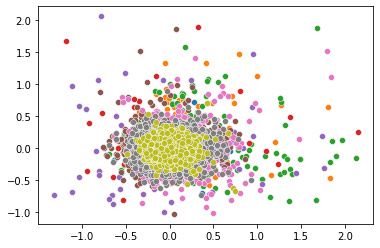

In [19]:
pca = PCA(n_components = 2)

for inlier in X_inliers_loop:
    X_encoded = encoder_net.predict(inlier)
    X_transform = pca.fit_transform(X_encoded)
    a = sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1])

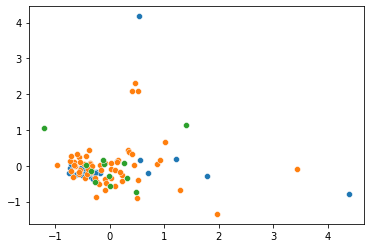

In [20]:
for inlier in X_outliers_loop:
    X_encoded = encoder_net.predict(inlier)
    X_transform = pca.fit_transform(X_encoded)
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1])

In [51]:
def plot_grid_img(X: np.ndarray, figsize: tuple = (10, 6)) -> None:
    n = X.shape[0]
    nrows = int(n**.5)
    ncols = int(np.ceil(n / nrows))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    n_subplot = 1
    for r in range(nrows):
        for c in range(ncols):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            plt.imshow(X[n_subplot-1, :, :, 0], cmap='gray')
            n_subplot += 1

In [52]:
n_sample = 16
X_sample = od.vae.sample(n_sample).numpy()
plot_grid_img(X_sample)

AttributeError: 'VAE' object has no attribute 'sample'

In [29]:
# Model Save
path = 'vae_encoder_net'
encoder_net.save(path)
path = 'vae_decoder_net'
decoder_net.save(path)

In [30]:
encoder_net2 = keras.models.load_model('encoder_net', compile=False)
decoder_net2 = keras.models.load_model('decoder_net', compile=False)
# vae = keras.models.load_model('vae', compile=False)

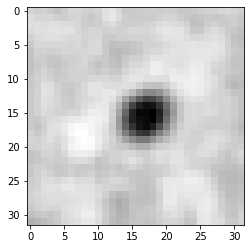

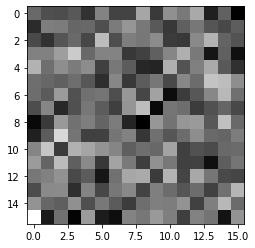

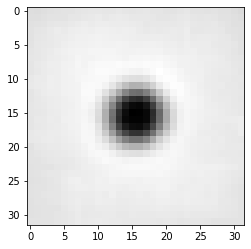

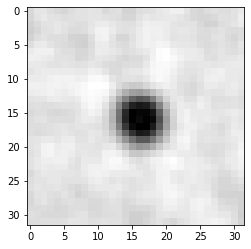

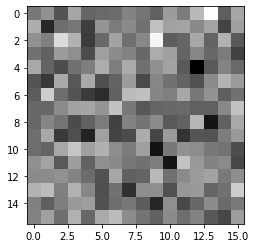

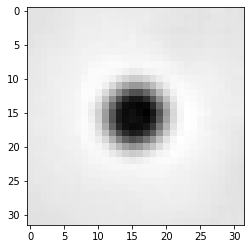

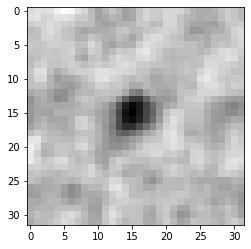

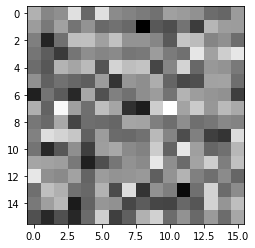

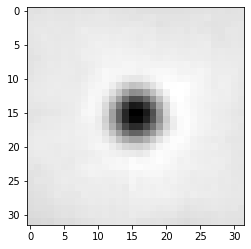

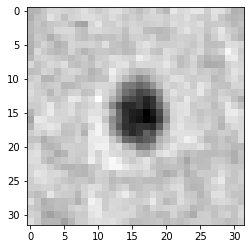

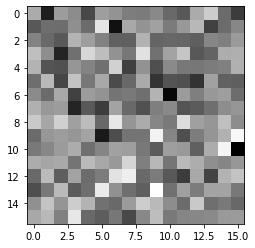

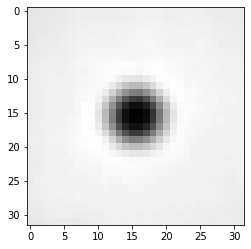

In [16]:
idx = 2094
X = X_inlier[idx].reshape(1, 32, 32, 1)
X_recon, X_z, X_z_mean, X_z_log_var = vae(X)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_z).reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_recon).reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1004
X = X_inlier[idx].reshape(1, 32, 32, 1)
X_recon, X_z, X_z_mean, X_z_log_var = vae(X)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_z).reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_recon).reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1002
X = X_inlier[idx].reshape(1, 32, 32, 1)
X_recon, X_z, X_z_mean, X_z_log_var = vae(X)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_z).reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_recon).reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1000
X = X_inlier[idx].reshape(1, 32, 32, 1)
X_recon, X_z, X_z_mean, X_z_log_var = vae(X)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_z).reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_recon).reshape(32, 32, 1), cmap="gray")
plt.show()

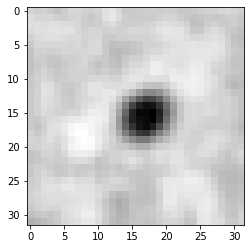

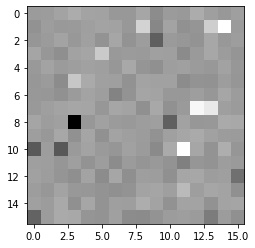

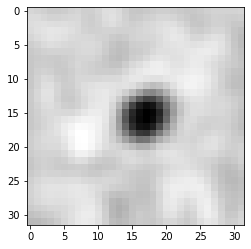

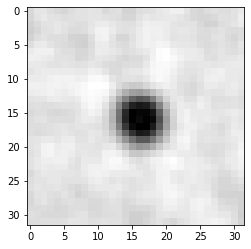

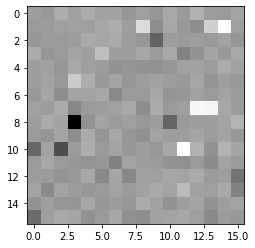

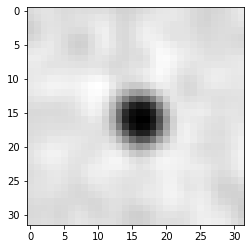

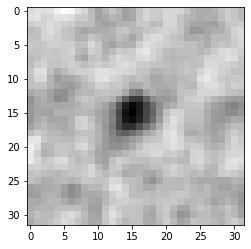

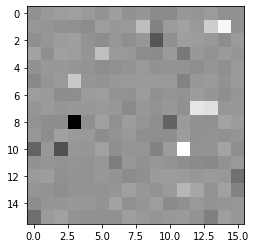

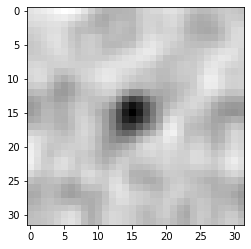

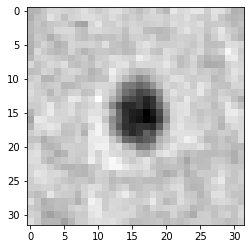

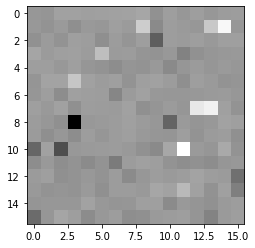

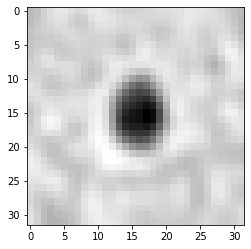

In [17]:
idx = 2094
X = X_inlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1004
X = X_inlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1002
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1000
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()

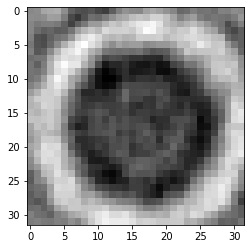

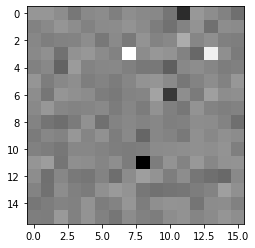

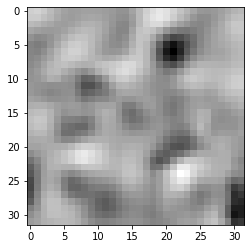

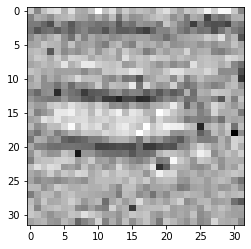

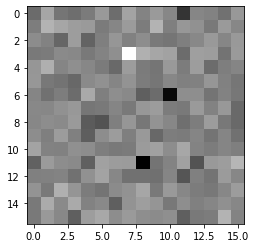

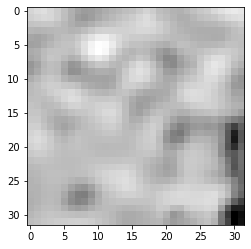

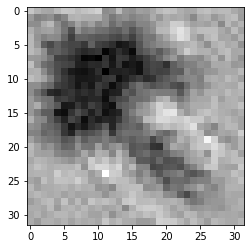

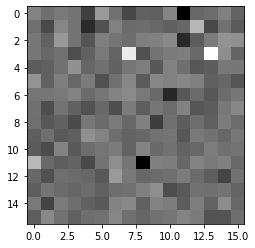

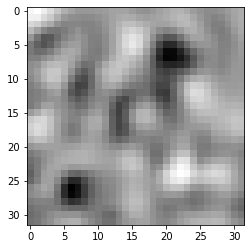

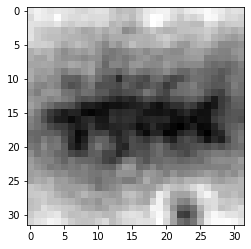

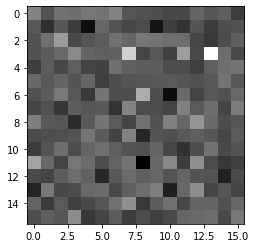

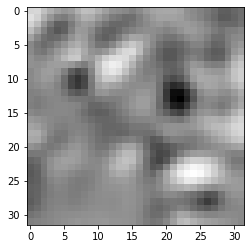

In [32]:
idx = 10
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net.predict(X)
X_recon = decoder_net.predict(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 2
X = X_outlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 54
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 78
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()

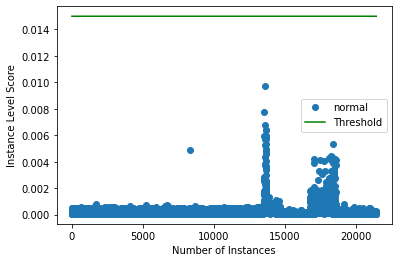

In [14]:
od_preds = od.predict(X_inlier,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True,
                      batch_size = 64
                     )
target = np.zeros(X_inlier.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

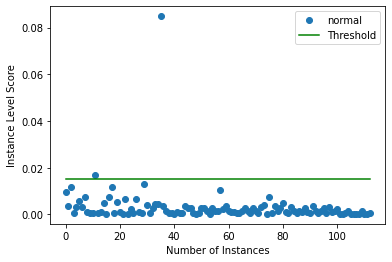

In [15]:
od_preds2 = od.predict(X_outlier,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True,
                      batch_size = 64
                     )
target2 = np.zeros(X_outlier.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels2 = ['normal', 'outlier']
plot_instance_score(od_preds2, target2, labels2, od.threshold)

In [17]:
od_preds2['data']['instance_score']

array([0.0095622 , 0.00350592, 0.0116745 , 0.00047748, 0.00324556,
       0.00561529, 0.00333833, 0.00735763, 0.00099312, 0.00042779,
       0.00051768, 0.0170815 , 0.00054198, 0.00083658, 0.00478048,
       0.00032093, 0.00736432, 0.01181952, 0.00071054, 0.00550801,
       0.00084749, 0.0003569 , 0.00649538, 0.00032335, 0.00243326,
       0.00053751, 0.0068049 , 0.00090624, 0.00047786, 0.01282025,
       0.00393539, 0.00064545, 0.0027503 , 0.00455797, 0.00459591,
       0.0848586 , 0.00361177, 0.00132678, 0.00058243, 0.0004    ,
       0.00036054, 0.00106827, 0.00081762, 0.00056765, 0.00381708,
       0.00281332, 0.00273105, 0.00055887, 0.00034228, 0.00039626,
       0.00285938, 0.00270247, 0.00165264, 0.00036187, 0.00284615,
       0.00127087, 0.00140863, 0.01037872, 0.00222343, 0.00373244,
       0.00167358, 0.00115377, 0.00124611, 0.00073359, 0.00077298,
       0.00157027, 0.00284966, 0.00134926, 0.00053227, 0.00255735,
       0.00142811, 0.00046612, 0.00316893, 0.00421934, 0.00027

In [31]:
od = OutlierVAE(threshold=0.01,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net2,  # can also pass VAE model instead
                decoder_net=decoder_net2,  # of separate encoder and decoder
                latent_dim=256,
                samples=2,
                beta = 1)

In [38]:
def test_VAE(od, perturb, y_limit=None):
    inlier_labels = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    test_inliers = []
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(0)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float().detach().numpy()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True)).detach().numpy()
        test_inliers.append(image.reshape(32, 32, 1))
    test_inliers = np.array(test_inliers).reshape(-1, 32, 32, 1)
    
    # Outliers
    test_outliers = []
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(1)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float().detach().numpy()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True)).detach().numpy()
        test_outliers.append(image.reshape(32, 32, 1))
        
    test_outliers = np.array(test_outliers).reshape(-1, 32, 32, 1)
    od_preds1 = od.predict(test_inliers,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True,
                      batch_size = 64
                     )
    od_preds2 = od.predict(test_outliers,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True,
                      batch_size = 64
                     ) 
    d_outliers = {"MSE Score": od_preds2['data']['instance_score'], "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(636, 1273, num=636)}
    d_inliers = {"MSE Score": od_preds1['data']['instance_score'], "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    g = sns.scatterplot(data=df1, x="Index of Image Patches", y="MSE Score", label="Inliers")
    g = sns.scatterplot(data=df2, x="Index of Image Patches", y="MSE Score", label="Outliers")
    g.set(ylim=(0, y_limit))
    plt.title('VAE - MSE Reconstruction Error Test Dataset')
    score_array = np.concatenate((od_preds1['data']['instance_score'], od_preds2['data']['instance_score']))
    label_array = inlier_labels+outlier_labels
    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)

{'fpr_at_95_tpr': 0.7955974842767296, 'detection_error': 0.42216981132075476, 'auroc': 0.7769866698310983, 'aupr_out': 0.7828833875020391, 'aupr_in': 0.7397254910630441}


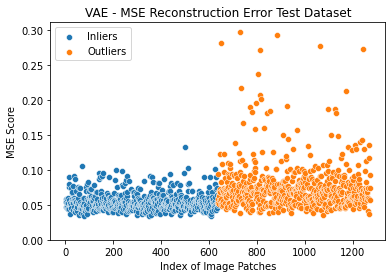

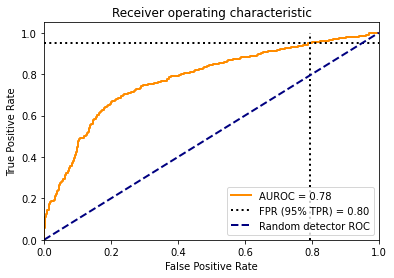

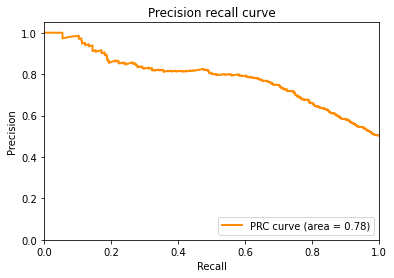

In [39]:
test_VAE(od, perturb = None, y_limit=None)

{'fpr_at_95_tpr': 0.7594339622641509, 'detection_error': 0.40408805031446543, 'auroc': 0.7850312487638939, 'aupr_out': 0.787629966720875, 'aupr_in': 0.7596529397120044}


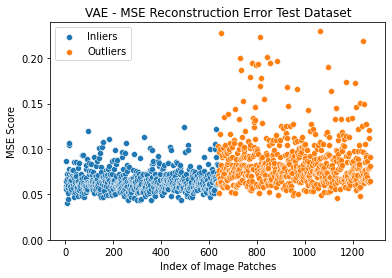

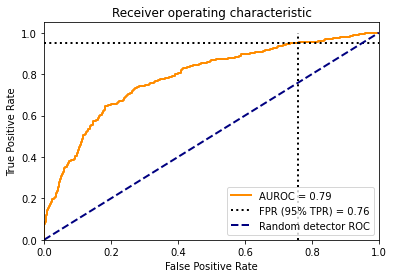

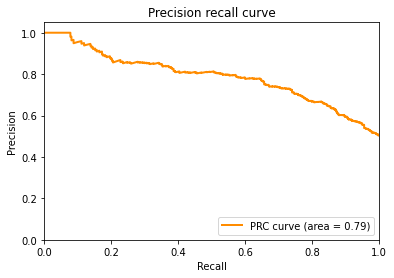

In [40]:
test_VAE(od, perturb = 'gaussian', y_limit=None)

{'fpr_at_95_tpr': 0.7830188679245284, 'detection_error': 0.41509433962264153, 'auroc': 0.7865219928009176, 'aupr_out': 0.7921175385657391, 'aupr_in': 0.7554722625810961}


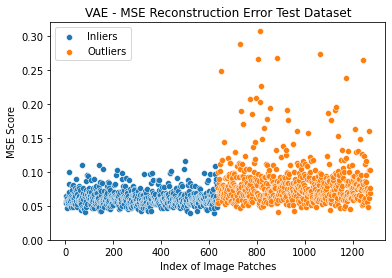

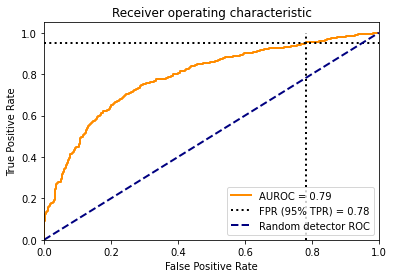

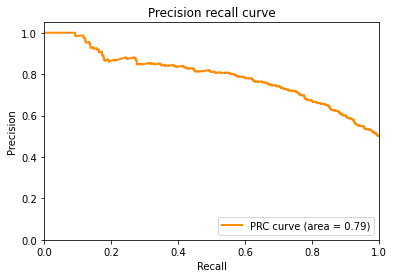

In [41]:
test_VAE(od, perturb = 's&p', y_limit=None)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

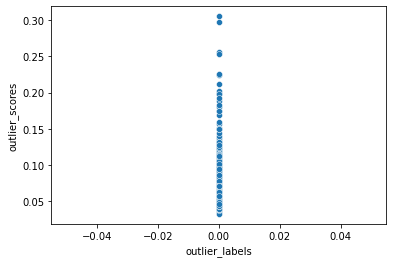

In [42]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_path = []
cl = "Unclassified" 

# Inliers
test_inliers = []
for img_path in Path(cl_path).glob("*.png"):
    outlier_labels.append(0)
    outlier_path.append(img_path)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float().detach().numpy()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True)).detach().numpy()
    test_inliers.append(image.reshape(32, 32, 1))
test_inliers = np.array(test_inliers).reshape(-1, 32, 32, 1)

od_preds = od.predict(test_inliers,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True,
                      batch_size = 64
                     )

d = {"outlier_scores": od_preds['data']['instance_score'], "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [43]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))